In [6]:
using HePPCAT, LinearAlgebra, Plots, Random, Statistics, StatsPlots, Printf
using Plots.PlotMeasures
include("plotting.jl")
include("petrels.jl")
include("grouse.jl")
include("shasta1.jl")
include("shasta2.jl")
include("batchHPPCACompletion.jl")

updatev! (generic function with 1 method)

In [34]:
# d, n, v, λ = 50, [200,800], [1,4], [4,2,1]
# d, n, v, λ = 50, [200,800], [0.1,1], [4,2,1]
# d, n, v, λ = 50, [200,800], [1e-4,1e-2], [4,2,1]

# d, n, v, λ = 100, [500,2000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 100, [2500,10000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 100, [3000,12000], [1e-4,1e-2], [4,2,1]

d, n, v, λ = 100, [3000,12000], [1e-4,1e-4], [4,2,1]
# d, n, v, λ = 100, [3000,9000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 1000, [2000,20000], [1e-4,1e-2], [4,2,1]
# d, n, v, λ = 500, [3000,12000], [1e-4,1e-2], [5,4,3,2,1]

# d, n, v, λ = 50, [500,2000], [1e-2,1e-2], [4,2,1]

# d, n, v, λ = 50, [100,1000], [1e-2,1], [4,2,1]
k, L = length(λ), length(v)
khat = k;

# num_trials = 10
num_trials = 2

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
# missing = 0.5
missing = 0.0
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ytrue[l] for l in 1:L]

### Streaming-setup
Ymat_true = hcat([Ytrue[l] for l=1:L]...)
Ymat = hcat([Y[l] for l=1:L]...)
vmat = vcat([v[l]*ones(n[l]) for l=1:L]...)
groups = Int64.(vcat([l*ones(n[l]) for l=1:L]...));
ΩY = abs.(Ymat) .> 0

dataIdx = randperm(sum(n))
Ymat = Ymat[:,dataIdx]
Ymat_true = Ymat_true[:,dataIdx]
ΩY = ΩY[:,dataIdx]
groups = groups[dataIdx]

### True model
Mtrue = HePPCATModel(U,λ,I(k),v)

# Ltrue = loglikelihood(Mtrue,Ytrue)
# stats_fcn(M) = loglikelihood(M,Ytrue) - Ltrue

# Ltrue = Ωloglikelihood(Mtrue,Ytrue,Ω)
# stats_fcn(M) = Ωloglikelihood(M,Ytrue,Ω) - Ltrue

# Ltrue = Ωloglikelihood2(Mtrue,Ytrue,Ω)
# stats_fcn(M) = Ωloglikelihood2(M,Ytrue,Ω) - Ltrue


HePPCATModel{Float64, Float64}([-0.13939697474265378 0.03728348878659718 -0.10567373286164174; -0.15407191316072236 -0.047383745440156444 -0.06473953172573939; … ; -0.11846869787526507 0.005292250028557054 0.11707272335164223; -0.1438917360208415 -0.07662065726422147 -0.0970262278821984], [4.0, 2.0, 1.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.0001, 0.0001])

In [35]:
function Fmeasure(M)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
    
#     return norm(M.F*M.F' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

Fmeasure (generic function with 1 method)

In [36]:
stats_fcn(M) = 0
δ = 0.1
λ = 0.998
Mpetrels = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mpetrels, Yrec, stats_log, err_log, time_log = PETRELS(Mpetrels,Ymat,ΩY,λ,δ,Fmeasure,stats_fcn)

(HePPCATModel{Float64, Float64}([-0.09529059369012034 -0.12698660245097138 0.08193811321245499; -0.15504336581908487 -0.06237111993332187 0.047524897892599845; … ; -0.08477631420709987 -0.05626360262938382 -0.13217589408997502; -0.16639540367920613 -0.03806687733186485 0.08288552644800455], [26.39261758059448, 21.93292389106307, 3.428653357916482], [0.9204416078463286 0.09510761198967554 0.3791329432888764; -0.31981891990710726 -0.374408753611587 0.870364259197532; -0.2247289590033212 0.9223733665716063 0.31420418142450707], [0.3885065552819107, 0.8688557289244971]), [0.11369988735962955 -0.3056609164776179 … -0.09660785288715257 0.1765234208492077; 0.06709013974735209 -0.24349364886478392 … -0.09552758693920829 0.1409016439407234; … ; -0.21960034886202737 -0.25525954014678254 … -0.04433512199943458 -0.4404236375726151; 0.14478959494335417 -0.20787502689645435 … -0.0951721533029167 0.2765116597241096], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1.3610809890290894

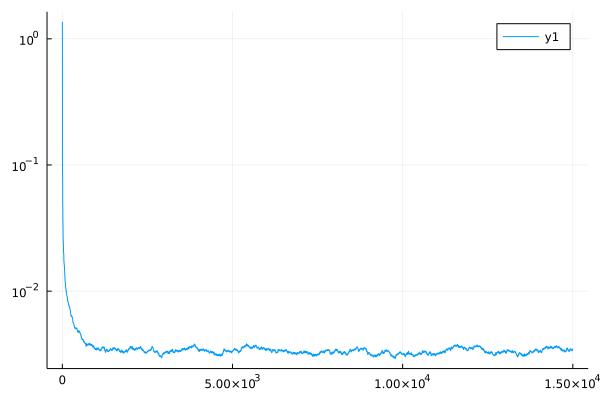

In [37]:
plot(err_log,yaxis=:log)

In [38]:
Mpetrels.λ

3-element Vector{Float64}:
 26.39261758059448
 21.93292389106307
  3.428653357916482

In [39]:
ΩY

100×15000 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     